## Introduction

As an NBA analytics enthusiast, I need to be able to get my hands on one thing: data. NBA data can be acquired from a few locations:
  - [NBA Stats](https://www.stats.nba.com)
  - [Basketball Reference](https://www.basketball-reference.com)
  - [ESPN](https://www.espn.com)
  - ...

The problem with most of these websites is their extremely confusing and contrived endpoints. Consider the most popular site [NBA Stats](https://www.stats.nba.com). Here are just a few of their endpoints:
  - `allstarballotpredictor`
  - `boxscoreadvancedv2`
  - `boxscorefourfactorsv2`
  - `boxscoremiscv2`
  - ...

Who needs all of this and what do each of them mean?! Moreover, take a look at what they return for a simple endpoint `commonallplayers`:
```
['PERSON_ID', 'DISPLAY_LAST_COMMA_FIRST', 'DISPLAY_FIRST_LAST', 'ROSTERSTATUS', 'FROM_YEAR', 'TO_YEAR', 'PLAYERCODE', 'TEAM_ID', 'TEAM_CITY', 'TEAM_NAME', 'TEAM_ABBREVIATION', 'TEAM_CODE', 'GAMES_PLAYED_FLAG', 'OTHERLEAGUE_EXPERIENCE_CH']
```
I don't need all this information.

Additionally, I've found that a lot of sites including stats.nba.com prevent multiple repeated requests from the same IP, making the simple data acquisition process heinous.

## The Solution

Basketball Reference, on the other hand, does not pose such a problem. 

Basketball Reference provides clear data output and does not. For all those questioning whether this is in compliance with their ToS, they explicitly state:

'As an aside, copyright law is clear that facts cannot be copyrighted, so you are free to reuse facts found on this site in accordance with copyright laws.'

Additionally, after stating that you shouldn't scrape the data, they tell you that you should scrape the data:

'However, I would point out that learning how to accumulate data is often a more valuable skill than actually analyzing the data, so we encourage you as a student or professional to learn how.'

## So how does one go about achieving this?

Typically, scraping is permormed on static websites using the Python `requests` library and `BeautifulSoup`. Consider the following example of scraping my own [homepage](https://www.vishaalagartha.github.io):

In [2]:
# Import relevant libraries
from requests import get
from bs4 import BeautifulSoup

r = get('https://vishaalagartha.github.io')
if r.status_code==200:
    soup = BeautifulSoup(r.content, 'html.parser')
    print(soup.prettify())

<!DOCTYPE html>
<html class="no-js" lang="en">
 <head>
  <meta charset="utf-8"/>
  <!-- begin SEO -->
  <title>
   Vishaal Agartha
  </title>
  <meta content="en-US" property="og:locale"/>
  <meta content="Vishaal Agartha" property="og:site_name"/>
  <meta content="Vishaal Agartha" property="og:title"/>
  <link href="https://vishaalagartha.github.io/" rel="canonical"/>
  <meta content="https://vishaalagartha.github.io/" property="og:url"/>
  <meta content="About me" property="og:description"/>
  <script type="application/ld+json">
   { "@context" : "http://schema.org", "@type" : "Person", "name" : "Vishaal Agartha", "url" : "https://vishaalagartha.github.io", "sameAs" : null }
  </script>
  <!-- end SEO -->
  <link href="https://vishaalagartha.github.io/feed.xml" rel="alternate" title="Vishaal Agartha Feed" type="application/atom+xml"/>
  <!-- http://t.co/dKP3o1e -->
  <meta content="True" name="HandheldFriendly"/>
  <meta content="320" name="MobileOptimized"/>
  <meta content="width=d

That was relatively easy!
## Static vs. Dynamic Content

The problem is that issuing a GET request to a static website returns all the data the user will see. However, issuing a GET request to a **dynamic** website, or a website that uses JavaScript to load content will not.

Consider the following url: https://www.basketball-reference.com/players/j/jamesle01.html.

If we go to this page we can clearly see that **Per 36 Minutes** is clearly a table on the page. But, this content is loaded dynamically. If we use the Chrome inspector we can see this quite clearly:

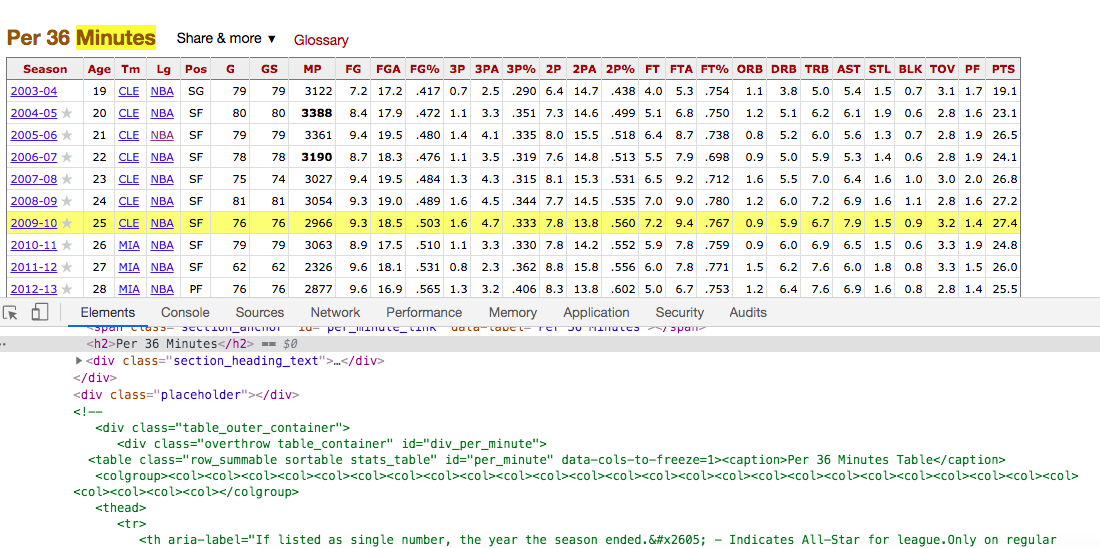


The Per 36 Minutes table is in green, indicating that is loaded dynamically! 
Moreover, let's try and find this table using a GET request:

In [4]:
r = get('https://www.basketball-reference.com/players/j/jamesle01.html')
if r.status_code==200:
    soup = BeautifulSoup(r.content, 'html.parser')
    # Find all tables on the website
    for table in soup.find_all('table'):
        # Print the 'id' attribute of the table
        print(table.attrs['id'])

per_game


Evidently, the `per_minute` table is not captured. So what's the workaround?

## Approach 1: Use a dynamic scraper

One approach is to use a dynamic scraper like [Selenium](https://selenium-python.readthedocs.io/).

Selenium and other dynamic scrapers launch a WebDriver or an instance of your browser which eventually loads ALL the content on the site. Then, you can provide your scraping logic by forcing the scraper to wait for certain selectors.

Another, excellent, but less used Python scraper is [pyppeteer](https://github.com/miyakogi/pyppeteer).
I initially started off by using this as my dynamic scraper. Let's take a look at how to do scrape this site using pyppeteer.

In [16]:
import pandas as pd
from pyppeteer import launch
from requests import get
from bs4 import BeautifulSoup
import asyncio
import nest_asyncio
nest_asyncio.apply()

async def get_player_selector(url, selector):
    # Launch the browser and a new page
    browser = await launch()
    page = await browser.newPage()
    await page.goto(url)
    await page.waitForSelector(f'{selector}')
    table = await page.querySelectorEval(f'{selector}', '(element) => element.outerHTML')
    await browser.close()
    # Use pandas to read the table easily
    return table

In [17]:
url = 'https://www.basketball-reference.com/players/j/jamesle01.html'
selector = '#per_minute'

table = asyncio.get_event_loop().run_until_complete(get_player_selector(url, selector))
table

'<table class="row_summable sortable stats_table now_sortable sliding_cols" id="per_minute" data-cols-to-freeze="1"><caption>Per 36 Minutes Table</caption>\n   <colgroup><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col></colgroup>\n   <thead>      \n      <tr>\n         <th aria-label="If listed as single number, the year the season ended.★ - Indicates All-Star for league.Only on regular season tables." data-stat="season" scope="col" class=" poptip sort_default_asc center" data-tip="If listed as single number, the year the season ended.<br>★ - Indicates All-Star for league.<br>Only on regular season tables.">Season</th>\n         <th aria-label="Player\'s age on February 1 of the season" data-stat="age" scope="col" class=" poptip sort_default_asc center" data-tip="Player\'s age on February 1 of the season">Age</th>\n         <th aria-label="Team" data-stat="team_id" scope="col" class=" popti

Aha! Now that get's the relevant content! We can also use the Pandas library to read this html table relatively easily:

In [18]:
df = pd.read_html(table)[0]
df

,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2003-04,19.0,CLE,NBA,SG,79.0,79.0,3122.0,7.2,17.2,...,0.754,1.1,3.8,5.0,5.4,1.5,0.7,3.1,1.7,19.1
1,2004-05,20.0,CLE,NBA,SF,80.0,80.0,3388.0,8.4,17.9,...,0.750,1.2,5.1,6.2,6.1,1.9,0.6,2.8,1.6,23.1
2,2005-06,21.0,CLE,NBA,SF,79.0,79.0,3361.0,9.4,19.5,...,0.738,0.8,5.2,6.0,5.6,1.3,0.7,2.8,1.9,26.5
3,2006-07,22.0,CLE,NBA,SF,78.0,78.0,3190.0,8.7,18.3,...,0.698,0.9,5.0,5.9,5.3,1.4,0.6,2.8,1.9,24.1
4,2007-08,23.0,CLE,NBA,SF,75.0,74.0,3027.0,9.4,19.5,...,0.712,1.6,5.5,7.0,6.4,1.6,1.0,3.0,2.0,26.8
5,2008-09,24.0,CLE,NBA,SF,81.0,81.0,3054.0,9.3,19.0,...,0.780,1.2,6.0,7.2,6.9,1.6,1.1,2.8,1.6,27.2
6,2009-10,25.0,CLE,NBA,SF,76.0,76.0,2966.0,9.3,18.5,...,0.767,0.9,5.9,6.7,7.9,1.5,0.9,3.2,1.4,27.4
7,2010-11,26.0,MIA,NBA,SF,79.0,79.0,3063.0,8.9,17.5,...,0.759,0.9,6.0,6.9,6.5,1.5,0.6,3.3,1.9,24.8
8,2011-12,27.0,MIA,NBA,SF,62.0,62.0,2326.0,9.6,18.1,...,0.771,1.5,6.2,7.6,6.0,1.8,0.8,3.3,1.5,26.0
9,2012-13,28.0,MIA,NBA,PF,76.0,76.0,2877.0,9.6,16.9,...,0.753,1.2,6.4,7.6,6.9,1.6,0.8,2.8,1.4,25.5


So that's one approach that works. But why didn't I use this approach?

**Performance**. I found my scraper to be extremely slow, especially when sending multiple requests. So, I found a workaround.

## Approach 2: Use a static scraper to a very targeted url

If you look at Basketball Reference's tables, that provide a very nice feature to embed an html table using [Sports Reference Widgets](https://widgets.sports-reference.com/). Take a peek here:

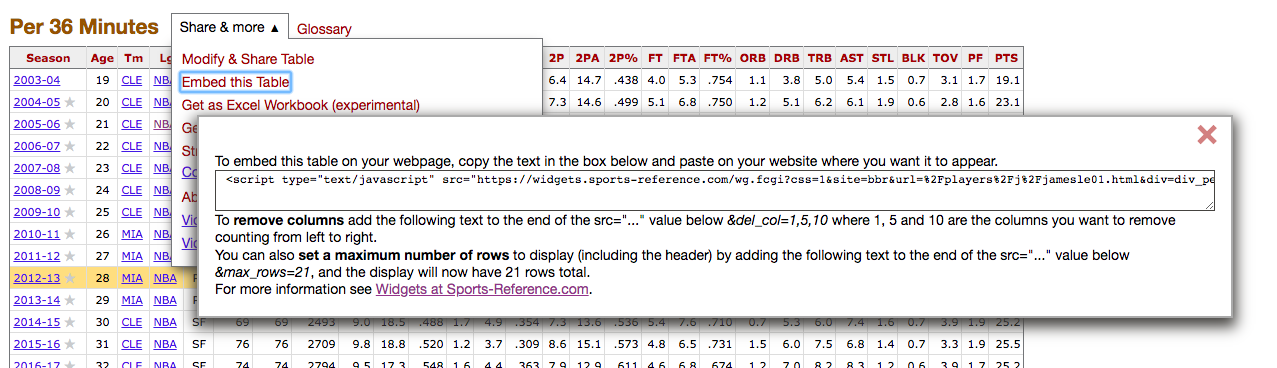

Instead of requesting the page itself, if we send a GET request to the `src` in the above image, we can get all the content **statically**. Here's an example:

In [19]:
r = get('https://widgets.sports-reference.com/wg.fcgi?css=1&site=bbr&url=%2Fplayers%2Fj%2Fjamesle01.html&div=div_per_minute')
if r.status_code==200:
    soup = BeautifulSoup(r.content, 'html.parser')
    table = soup.find('table')

In [20]:
df = pd.read_html(str(table))[0]
df

,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2003-04,19.0,CLE,NBA,SG,79.0,79.0,3122.0,7.2,17.2,...,0.754,1.1,3.8,5.0,5.4,1.5,0.7,3.1,1.7,19.1
1,2004-05,20.0,CLE,NBA,SF,80.0,80.0,3388.0,8.4,17.9,...,0.750,1.2,5.1,6.2,6.1,1.9,0.6,2.8,1.6,23.1
2,2005-06,21.0,CLE,NBA,SF,79.0,79.0,3361.0,9.4,19.5,...,0.738,0.8,5.2,6.0,5.6,1.3,0.7,2.8,1.9,26.5
3,2006-07,22.0,CLE,NBA,SF,78.0,78.0,3190.0,8.7,18.3,...,0.698,0.9,5.0,5.9,5.3,1.4,0.6,2.8,1.9,24.1
4,2007-08,23.0,CLE,NBA,SF,75.0,74.0,3027.0,9.4,19.5,...,0.712,1.6,5.5,7.0,6.4,1.6,1.0,3.0,2.0,26.8
5,2008-09,24.0,CLE,NBA,SF,81.0,81.0,3054.0,9.3,19.0,...,0.780,1.2,6.0,7.2,6.9,1.6,1.1,2.8,1.6,27.2
6,2009-10,25.0,CLE,NBA,SF,76.0,76.0,2966.0,9.3,18.5,...,0.767,0.9,5.9,6.7,7.9,1.5,0.9,3.2,1.4,27.4
7,2010-11,26.0,MIA,NBA,SF,79.0,79.0,3063.0,8.9,17.5,...,0.759,0.9,6.0,6.9,6.5,1.5,0.6,3.3,1.9,24.8
8,2011-12,27.0,MIA,NBA,SF,62.0,62.0,2326.0,9.6,18.1,...,0.771,1.5,6.2,7.6,6.0,1.8,0.8,3.3,1.5,26.0
9,2012-13,28.0,MIA,NBA,PF,76.0,76.0,2877.0,9.6,16.9,...,0.753,1.2,6.4,7.6,6.9,1.6,0.8,2.8,1.4,25.5


Just as good! Note that this workaround only works for Sports Reference websites and will not work for other website with dynamically loaded content. In that case you will have to use another dynamic scraper a la Selenium or Pyppeter.

## Results

My Basketball Reference Scraper is now fully functional and highly used across many NBA data enthusiasts. Here is the final product:

[basketball\_reference\_scraper](https://github.com/vishaalagartha/basketball_reference_scraper)

**An API client to access statistics and data from** [**Basketball Reference**](https://www.basketball-reference.com/) **via scraping written in Python.**


    pip install basketball-reference-scraper==v1.0.1

All the methods are documented [here](https://github.com/vishaalagartha/basketball_reference_scraper/blob/master/API.md) along with [examples](https://github.com/vishaalagartha/basketball_reference_scraper/blob/master/examples.py).

Please feel free to check out the [GitHub repo](https://github.com/vishaalagartha/basketball_reference_scraper) as well.

Anyone is more than welcome to create issues regarding any problems that you may experience. I will try my best to be as responsive as possible. Please feel free to provide criticism as I would love to improve this even further!